<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
1. [Einleitung](#1)
2. [Package- und Datenimport](#2)  
3. [Deskriptive Analyse](#3)  
    3.1 [Datenüberblick](#3.1)   
    3.2 [Datentypen](#3.2)  
    3.3 [Betrachtung der Verteilung](#3.3)   
    3.4 [Analyse der Kategorischen Variablen](#3.4)  
    3.5 [Fehlende Werte](#3.5)   
    3.6 [Ausreißer](#3.6)  
    3.7 [Zeitreihenanalyse](#3.7)   
    3.8 [Korrelationen](#3.8)  
4. [Daten anpassen](#4)  
5. [Geeignete Merkmale](#5)  
6. [Vergleichsmetrik](#6)
7. [ML Verfahren 1](#7)
8. [ML Verfahren 2](#8)
9. [Vergleich](#9)

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

## 2. Package- und Datenimport <a id="2"></a> <br>

In [1]:
import calendar
import locale
import zipfile

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date, datetime, timedelta

from matplotlib.pyplot import rcParams
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima -q
import pmdarima as pm

# Machine Learning Verfahren Nummer 2 - Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
# from dask.distributed import Client
import holidays

sns.set_style(style='white') # Hintergrund der Plots


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\nikla\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

In [3]:
# Maximale Anzahl an Spalten und Zeilen, beim anzeigen von Dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

## 3. Deskriptive Analyse <a id="3"></a> <br>

### 3.1 Datensatzüberblick <a id="3.1"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.


In [3]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                                 "DayOfWeek":"Wochentag",
                                                                 "Date":"Datum",
                                                                 "Sales":"Umsatz",
                                                                 "Customers":"Kundenanzahl",
                                                                 "Open":"Geoeffnet",
                                                                 "Promo":"Aktionstag",
                                                                 "StateHoliday":"Feiertag",
                                                                 "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                                  "Store":"Filiale",
                                                                  "DayOfWeek":"Wochentag",
                                                                  "Date":"Datum",
                                                                  "Open":"Geoeffnet",
                                                                  "Promo":"Aktionstag",
                                                                  "StateHoliday":"Feiertag",
                                                                  "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                                  "StoreType":"Filialentyp",
                                                                  "Assortment":"Sortiment",
                                                                  "CompetitionDistance":"Wettbewerberentfernung",
                                                                  "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                                  "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                                  "Promo2": "Teilnahme_Langzeitaktion",
                                                                  "Promo2SinceWeek":"Aktion_seit_Woche",
                                                                  "Promo2SinceYear":"Aktion_seit_Jahr",
                                                                  "PromoInterval":"Aktionsmonate"})




# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\nikla\AppData\Local\Temp\ipykernel_27952\3191597121.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format) |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja).|
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").|

**Datensätze: Train, Test, Store, Train_x_store**

In [ ]:
display(train.head())

In [ ]:
display(test.head())

In [ ]:
display(store.head())

In [ ]:
display(train_x_store.head())

### 3.2 Datentypen <a id="3.2"></a> <br>

In [ ]:
# Datentypen vor Korrektur
train_x_store.dtypes

In [4]:
# Anpassungen Train
train_x_store["Datum"] = pd.to_datetime(train_x_store["Datum"])
train_x_store["Wochentag"] = train_x_store["Datum"].dt.weekday

# Anpassungen Test
test_x_store["Datum"] = pd.to_datetime(test_x_store["Datum"])
test_x_store["Wochentag"] = test_x_store["Datum"].dt.weekday

In [ ]:
# Datentypen nach Korrektur
display(train_x_store.dtypes)

display(test_x_store.dtypes)

### 3.3 Neue Spalten <a id="3.2"></a> <br>

Nach der Datentypenkorrektur werden folgende neuen Spalten aus den bereits existierenden hinzugefügt:
| Originale Spalte              | Neue Spalte                           | Beschreibung                                                              |
|-------------------------------|---------------------------------------|---------------------------------------------------------------------------|
| `Datum`                       | `Tag`                                 | Gibt den Tag aus der ursprünglichen Spalte Datum an (von 1 bis 31).       |
| `Datum`                       | `Monat`                               | Gibt den Monat aus der ursprünglichen Spalte Datum an (von 1 bis 12).     |
| `Datum`                       | `Jahr`                                | Gibt das Jahr aus der ursprünglichen Spalte Datum an.             	    |
| `Datum`                       | `Quartal`                             | Gibt das Quartal aus der ursprünglichen Spalte Datum an (von 1 bis 4).    |
| `Umsatz und Kundenanzahl`     | `UmsatzProKunde`                      | Gibt prozentual den Umsatz je Kunde pro Tag an.                           |

In [5]:
neue_spalten = {
    "Tag": train_x_store["Datum"].dt.day,
    "Monat": train_x_store["Datum"].dt.month,
    "Jahr": train_x_store["Datum"].dt.year,
    "Quartal": train_x_store["Datum"].dt.quarter
}

# Dataframe teilen, um die neuen Spalten in gewünschter Reihenfolge einzufügen
train_x_store_before = train_x_store.iloc[:, :1]
train_x_store_after = train_x_store.iloc[:, 1:]

# Alten Dataframe mit den neuen Spalten zusammenführen
train_x_store = pd.concat([train_x_store_before, pd.DataFrame(neue_spalten), train_x_store_after], axis=1)

display(train_x_store)

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,...,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,31,7,2015,3,4,2015-07-31,5263,555,1,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,30,7,2015,3,3,2015-07-30,5020,546,1,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,29,7,2015,3,2,2015-07-29,4782,523,1,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,28,7,2015,3,1,2015-07-28,5011,560,1,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,27,7,2015,3,0,2015-07-27,6102,612,1,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,1,2013,1,5,2013-01-05,4771,339,1,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,4,1,2013,1,4,2013-01-04,4540,326,1,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,3,1,2013,1,3,2013-01-03,4297,300,1,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,2,1,2013,1,2,2013-01-02,3697,305,1,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [6]:
neue_spalten = { "UmsatzProKunde":  train['Umsatz']/train['Kundenanzahl'] }

# Dataframe teilen, um die neuen Spalten in gewünschter Reihenfolge einzufügen
train_x_store_before = train_x_store.iloc[:, :9]
train_x_store_after = train_x_store.iloc[:, 9:]

# Alten Dataframe mit den neuen Spalten zusammenführen
train_x_store = pd.concat([train_x_store_before, pd.DataFrame(neue_spalten), train_x_store_after], axis=1)

display(train_x_store)

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,UmsatzProKunde,...,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,31,7,2015,3,4,2015-07-31,5263,555,9.482883,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,30,7,2015,3,3,2015-07-30,5020,546,9.702400,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,29,7,2015,3,2,2015-07-29,4782,523,10.126675,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,28,7,2015,3,1,2015-07-28,5011,560,9.342457,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,27,7,2015,3,0,2015-07-27,6102,612,8.626118,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5,1,2013,1,5,2013-01-05,4771,339,NaN,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017205,1115,4,1,2013,1,4,2013-01-04,4540,326,NaN,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017206,1115,3,1,2013,1,3,2013-01-03,4297,300,NaN,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1017207,1115,2,1,2013,1,2,2013-01-02,3697,305,NaN,...,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


### 3.4 Betrachtung der Verteilung <a id="3.3"></a> <br>

Es werden die statistischen Kennzahlen für den train_x_store-Datensatz berechnet, auf drei Dezimalstellen gerundet und die Datentypen angezeigt.

In [ ]:
describe = round(train_x_store.describe(include='all'), 3)
dtypes = pd.DataFrame(train_x_store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

### 3.5 Analyse der kategorischen Variablen <a id="3.4"></a> <br>



##### Betrachtung der Filialtypen und der Verteilung der Filialen auf diese Typen

In [ ]:
df_filialentyp = pd.DataFrame(data = store["Filialentyp"].value_counts()).rename(columns= {"count": "Anzahl"})
df_filialentyp["Anteil"] = round(df_filialentyp["Anzahl"] / df_filialentyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp.sort_index(inplace = True)
display(df_filialentyp)

Verteilung der Kundenzahlen und Umsätze auf die Filialtypen

In [ ]:
df_filialentyp_x = train_x_store.groupby('Filialentyp')[['Kundenanzahl', 'Umsatz']].sum()

df_filialentyp_x = pd.merge(df_filialentyp, df_filialentyp_x, on ="Filialentyp")

df_filialentyp_x["Kundenzahl_pro_Filiale"] = round(df_filialentyp_x["Kundenanzahl"] / df_filialentyp_x["Anzahl"], 0).astype(int)
df_filialentyp_x["Umsatz_pro_Filiale"] = round(df_filialentyp_x["Umsatz"] / df_filialentyp_x["Anzahl"], 0).astype(int)

# Reihenfolge der Spalten ändern
df_filialentyp_x = df_filialentyp_x[["Anzahl", "Anteil", "Kundenanzahl", "Kundenzahl_pro_Filiale", "Umsatz", "Umsatz_pro_Filiale"]]

display(df_filialentyp_x)

##### Betrachtung der Sortimente und der Verteilung der Sortimente auf die Filialen

In [ ]:
df_sortimenttyp = pd.DataFrame(data = store["Sortiment"].value_counts()).rename(columns= {"count": "Anzahl"})
df_sortimenttyp["Anteil"] = round(df_sortimenttyp["Anzahl"] / df_sortimenttyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_sortimenttyp.sort_index(inplace = True)
display(df_sortimenttyp)

##### Betrachtung der Sortimente und der Verteilung der Sortimente auf die Filialen unter Berücksichtigung der Filialtypen

In [ ]:
df_filialentyp_x_sortimenttyp = pd.DataFrame(data = store[["Filialentyp", "Sortiment"]].value_counts()).rename(columns= {"count": "Anzahl"})

df_filialentyp_x_sortimenttyp["Gruppenanteil"] = round(df_filialentyp_x_sortimenttyp["Anzahl"] / df_filialentyp_x_sortimenttyp.groupby(level = "Filialentyp")["Anzahl"].transform("sum") * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp_x_sortimenttyp["Gesamtanteil"] = round(df_filialentyp_x_sortimenttyp["Anzahl"] / df_filialentyp_x_sortimenttyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp_x_sortimenttyp.sort_index(inplace = True)
display(df_filialentyp_x_sortimenttyp)

Von den Filialen des Typs a haben 381 das Sortiment a, damit haben 63,29% der Filialen des Typs a das Sortiment a, was 34,17% aller Filialtyps und Sortimentskombinationen ausmacht.

##### Betrachtung der Angabe Feiertag (Häufigkeit der einzelnen Ausprägungen)

In [ ]:
df_feiertag = pd.DataFrame(data= train_x_store["Feiertag"].value_counts()).rename(columns= {"count": "Anzahl"})
display(df_feiertag)

Aus irgendeinem Grund taucht die 0 (kein Feiertag) zwei mal als Ausprägungstyp auf, daher untersuchen wir den Datentyp.

In [ ]:
for index in df_feiertag.index:
    print(f"{index}: {type(index)}")

Die Kategorie 0 (kein Feiertag) ist einmal als str und einmal als int codiert. Das passen wir im folgenden an.

In [7]:
train_x_store["Feiertag"] = train_x_store["Feiertag"].astype(str)

df_feiertag = pd.DataFrame(data= train_x_store["Feiertag"].value_counts()).rename(columns= {"count": "Anzahl"})
display(df_feiertag)

for index in df_feiertag.index:
    print(f"{index}: {type(index)}")

,Anzahl
Feiertag,
0,986159
a,20260
b,6690
c,4100


0: <class 'str'>
a: <class 'str'>
b: <class 'str'>
c: <class 'str'>


In [ ]:
df_feiertag["Anteil"] = round(df_feiertag["Anzahl"] / df_feiertag["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_feiertag)

97% der Datenpunkte haben für das Merkmal Feiertag die Ausprägung 0 (kein Feiertag). Damit machen die Feiertage rund 3% der in den Daten enthaltenen Tage aus. Das entspricht dem Erwartungswert, da in Deutschland die Zahl der gesetzlichen Feiertage, je nach Bundesland zwischen 10 und 12 liegt (pro Jahr) --> [11 / 365 = 0,03]

##### Geöffnet

In [ ]:
df_geoeffnet = pd.DataFrame(data= train_x_store["Geoeffnet"].value_counts()).rename(columns= {"count": "Anzahl"})
df_geoeffnet["Anteil"] = round(df_geoeffnet["Anzahl"] / df_geoeffnet["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_geoeffnet)

Von den Datenpunkten im Datensatz train_x_store haben 83% die Ausprägung "Geöffnet" = 1 und 17% die Ausprägung "Geoeffnet" = 0.

In Ferien oder an Feiertagen geöffnet

In [ ]:
df_geoeffnet = pd.DataFrame(data= train_x_store[["Schulferien", "Feiertag", "Geoeffnet"]].value_counts()).rename(columns= {"count": "Anzahl"})
df_geoeffnet["Anteil"] = round(df_geoeffnet["Anzahl"] / df_geoeffnet["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_geoeffnet)

66,88% der Datenpunkte im Datensatz train_x_store besitzen die Ausprägungskombination (Geoffnet, keine Ferien, kein Feiertag)

##### Schulferien und Feiertag

In [ ]:
df_ferien_x_feiertag = pd.DataFrame(data= train_x_store[["Schulferien", "Feiertag"]].value_counts()).rename(columns= {"count": "Anzahl"})
df_ferien_x_feiertag["Anteil"] = round(df_ferien_x_feiertag["Anzahl"] / df_ferien_x_feiertag["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_ferien_x_feiertag)

### 3.6 Fehlende Werte<a id="3.5"></a> <br>

Überblick über den zeitlichen Verlauf (liegen für jeden Tag Angaben vor)

In [ ]:
# Anzahl Tage im Datensatz
number_of_days = len(pd.unique(train_x_store["Datum"]))

# Anzahl an Tagen zwischen der ersten und letzten Datumsangabe
first_day= train_x_store["Datum"].min()
last_day = train_x_store["Datum"].max()
expected_number_of_days = (last_day - first_day).days + 1

print(f"Anzahl an Tagen im Datensatz: {number_of_days}\n"
      + f"Differenz zwischen kleinster und größter Datumsangabe (in Tagen): {expected_number_of_days-1}\n"
      + f"Erwarte Anzahl an Tagen im Datensatz: {expected_number_of_days}")

Die Anzahl der Tage für den Datenpunkte im Datensatz vorhanden sind deckt sich mit der Zeitspanne zwischen der ersten und letzten Datumsangabe im Datensatz. Es gibt also keinen Tag an dem uns alle Werte fehlen.

Überischt über die Filialen:
- liegen im Datensatz für alle Filialen und für jeden Tag Werte vor?

In [ ]:
# Anzahl an Filian
number_of_stores = len(pd.unique(train_x_store["Filiale"]))

stores_with_missing_data = train_x_store["Filiale"].value_counts()
stores_with_missing_data = stores_with_missing_data[stores_with_missing_data != number_of_days]

number_of_stores_with_missing_data = len(stores_with_missing_data)

print(f"Anzahl Filialen bei denen Daten fehlen: {number_of_stores_with_missing_data}")

Für insgesamt 181 Filialen sind die Daten unvollständig. Der Grund dafür könnte sein, dass die Filialen im Laufe des betrachteten Zeitraus eröffnet oder geschlossen haben. Dafür betrachten wir im folgenden den zeitlichen Verlauf.

In [ ]:
train_x_store_gp_date = train_x_store.groupby("Datum")

number_of_stores_by_date = {}

for date, df in train_x_store_gp_date:
    number_of_stores_by_date[date] = len(pd.unique(df["Filiale"]))
 
df_number_of_stores_by_date = pd.DataFrame.from_dict(number_of_stores_by_date, orient = "index", columns= ["Number_of_Stores"])

fig, ax = plt.subplots(figsize= (20,6))

ax.set_title("Anzahl der Filialen für die pro Tag ein Datensatz vorliegt")
ax.plot(df_number_of_stores_by_date.index, df_number_of_stores_by_date["Number_of_Stores"])
ax.grid()
plt.show()

Über einen Zeitraum von ca. 6 Monaten fehlen die Daten für 181 Filialen. Da der Zeitraum für den dieses Datenpunkte fehlen, innerhalb des Betrachtungshorzionts und nicht etwa am Rande liegen, ist die Theorie der Neueröffnung oder dauerhaften Schließung hinfällig.

Aber wie viele Daten fehlen insgesamt?

In [ ]:
number_of_datapoints = len(train_x_store)
expected_number_of_datapoint = number_of_stores * number_of_days

number_of_missing_datapoints = expected_number_of_datapoint - number_of_datapoints

number_of_datapoints, expected_number_of_datapoint, number_of_missing_datapoints
print(f"Anzahl erhaltener Datenpunkte: {number_of_datapoints}\n"
      + f"Anzahl erwarteter Datenpunkte: {expected_number_of_datapoint-1}\n"
      + f"Anzahl fehlender Datenpunkte: {number_of_missing_datapoints} ({round(number_of_missing_datapoints / expected_number_of_datapoint * 100, 2)}%)")

Insgesamt fehlen 33121 Datenpunkte.

In [ ]:
# Fehlende Werte in Train_x_store
missing_data_abs = train_x_store.isnull().sum()
missing_data_per = ( round(train_x_store.isnull().sum()/train_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

#### Fehlende Werte im Train-Store-Datensatz

##### Spalte: Wettbewerberentfernung

Im Datensatz gibt es einige Spalten mit fehlenden Werten, welche wir uns nach und nach ansehen werden. Wir beginnen mit der Spalte _Wettbewerberentfernung_, worin 2.642 NaN-Werte gefunden wurden.

In [ ]:
train_x_store[pd.isnull(train_x_store.Wettbewerberentfernung)].head()

In [ ]:
describe = pd.DataFrame(round(train_x_store["Wettbewerberentfernung"].describe(), 3))
display(describe)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(train_x_store["Wettbewerberentfernung"], bins=50, edgecolor='white')
plt.title('Verteilung der Wettbewerberentfernungen')
plt.xlabel('Wettbewerberentfernung')
plt.ylabel('Anzahl')

median = train_x_store["Wettbewerberentfernung"].median()
mean = train_x_store["Wettbewerberentfernung"].mean()

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')

plt.legend()
plt.grid(True)

Wir nehmen  an, dass die Daten einfach nicht vorhanden sind und ersetzen daher die fehlenden Werte in _Wettbewerberentfernung_ mit dem Median.
Warum Median?
-  Robustheit gegenüber Ausreißern: Der Median ist weniger anfällig für Ausreißer im Vergleich zum arithmetischen Mittelwert
- Verteilung der Daten: Wenn die Verteilung der Daten nicht symmetrisch ist oder nicht normal verteilt ist, kann der Median oft die zentrale Tendenz der Daten besser widerspiegeln als der Mittelwert. Dies ist häufig der Fall bei Daten, die rechtsschief oder linksschief verteilt sind.
- Der Median ist ein besserer Indikator für die zentrale Tendenz der Daten, insbesondere wenn man bedenkt, dass die Standardabweichung (7.706,913) relativ hoch ist. Dies deutet darauf hin, dass die Daten möglicherweise eine gewisse Varianz oder Ausreißer aufweisen könnten, die den Mittelwert verzerren würden.

In [8]:
train_x_store["Wettbewerberentfernung"].fillna(train_x_store["Wettbewerberentfernung"].median(), inplace=True)

##### Spalten: _Wettbewerber_Eroeffnet_seit_Monat_, _Wettbewerber_Eroeffnet_seit_Jahr_

In [ ]:
display(train_x_store[(train_x_store.Wettbewerberentfernung>0) & (pd.isnull(train_x_store.Wettbewerber_Eroeffnet_seit_Monat))].head())
display(train_x_store[(train_x_store.Wettbewerberentfernung>0) & (pd.isnull(train_x_store.Wettbewerber_Eroeffnet_seit_Jahr))].head())

Da zwischen den Spalten Wettbewerberentfernung, _Wettbewerber_Eroeffnet_seit_Monat_ und _Wettbewerber_Eroeffnet_seit_Jahr_ kaum eine Korrelation (Korrelationskoeffizienten liegen nah um 0 herum) besteht und die Anzahl an fehlenden Werten (32%) zu groß ist um sie zu entfernen, werden die fehlenden Werte durch den jewieligen Median ersetzt.

In [9]:
median_W_Eroeffnet_seit_Monat = train_x_store['Wettbewerber_Eroeffnet_seit_Monat'].median()
median_W_Eroeffnet_seit_Jahr = train_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].median()

train_x_store['Wettbewerber_Eroeffnet_seit_Monat'].fillna(median_W_Eroeffnet_seit_Monat, inplace=True)
train_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].fillna(median_W_Eroeffnet_seit_Jahr, inplace=True)

##### Spalten: _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_, _Aktion_seit_Jahr_, _Aktionsmonate_

Als nächstes sehen wir uns die Spalten _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_ und _Aktion_seit_Jahr_ an. Sofern eine Filiale an einer Langzeitaktion teilnimmt, sollten auch Monat und Jahr nicht fehlen. Da dies der Fall ist, können wir die fehlenden Werte durch Null ersetzen.

In [ ]:
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Woche))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Jahr))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktionsmonate))])

In [10]:
train_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
train_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)
train_x_store["Aktionsmonate"].fillna(0, inplace=True)

#### Fehlende Werte im Test-Store-Datensatz

In [ ]:
# Fehlende Werte in Test_x_store
missing_data_abs = test_x_store.isnull().sum()
missing_data_per = ( round(test_x_store.isnull().sum()/test_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

##### Spalte: Geoffnet

In [ ]:
test_x_store.head()

In [ ]:
# Nur Filiale 622 hat NaNs in der Spalte Geoffnet
display(test_x_store[pd.isnull(test_x_store.Geoeffnet)])

In [ ]:
# Datum extrahieren, wo Geoffnet fehlende Werte hat
unique_dates = test_x_store[pd.isnull(test_x_store['Geoeffnet'])]['Datum'].unique()

# Datensatz nach dem Datum filtern
filtered_df = test_x_store[test_x_store['Datum'].isin(unique_dates)]

# Nach Datum und Geoffnet gruppieren
grouped = filtered_df.groupby(['Datum', 'Geoeffnet']).size().unstack(fill_value=0)
grouped.columns = ['Anzahl_Geschlossen', 'Anzahl_Geoeffnet']

display(grouped)

Da die aller meisten Filialen an den ausgewählten Tagen geöffnet sind, werden die fehlenden Werte in der Spalte _Geoffnet_ ebenfalls auf 1 gesetzt.

In [11]:
test_x_store["Geoeffnet"].fillna(1, inplace=True)

##### Restliche Spalten mit fehlenden Werten

Hier gehen wir genau so vor, wie im Train-Store-Datensatz.

In [12]:
# Median des Train-Datensatzes benutzen
test_x_store["Wettbewerberentfernung"].fillna(test_x_store["Wettbewerberentfernung"].median(), inplace=True)

In [13]:
# Median des Train-Datensatzes benutzen
median_W_Eroeffnet_seit_Monat = test_x_store['Wettbewerber_Eroeffnet_seit_Monat'].median()
median_W_Eroeffnet_seit_Jahr = test_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].median()

test_x_store['Wettbewerber_Eroeffnet_seit_Monat'].fillna(median_W_Eroeffnet_seit_Monat, inplace=True)
test_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].fillna(median_W_Eroeffnet_seit_Jahr, inplace=True)

In [14]:
test_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
test_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)
test_x_store["Aktionsmonate"].fillna(0, inplace=True)

In [ ]:
test_x_store.head()

#### Prüfen, ob noch fehlende Werte vorhanden sind

In [ ]:
missing_data_abs = train_x_store.isnull().sum()
missing_data_per = ( round(train_x_store.isnull().sum()/train_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

In [ ]:
missing_data_abs = test_x_store.isnull().sum()
missing_data_per = ( round(test_x_store.isnull().sum()/test_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

### 3.7 Ausreißer <a id="3.6"></a> <br>

Hier betrachten wir verschiedene Umsatzszenarien, um den Datensatz besser zu verstehen und Ausreißer zu ermitteln.

In [ ]:
kein_umsatz = train_x_store[train_x_store.Umsatz==0.0]
print("An " + str(kein_umsatz.shape[0]) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(kein_umsatz.shape[0]/train_x_store.shape[0]*100,2)) + "%) wurde kein Umsatz gemacht.")

In [ ]:
kein_umsatz_und_geoeffnet = train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==1)]
print("An " + str(kein_umsatz_und_geoeffnet.shape[0]) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(kein_umsatz_und_geoeffnet.shape[0]/train_x_store.shape[0]*100,2)) + "%) wurde kein Umsatz gemacht, obwohl diese Filialen geöffnet waren.")

In [ ]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_und_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

Offene Filialen ohne Umsatz sind zwar selten und nicht unrealistisch, aber wären für die Vorhersage problematisch. Außerdem werden auch alle Zeilen entfernt, in denen die Filiale geschlossen war und es keinen Umsatz gab.

In [15]:
train_x_store = train_x_store.drop( train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==1)].index )
train_x_store = train_x_store.drop( train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==0)].index )

Was jedoch unrealistisch wäre, sind geschlossene Filialen mit Umsatz - das prüfen wir als nächstes.

In [ ]:
umsatz_geschlossen = train_x_store[(train_x_store["Umsatz"]!= 0) & (train_x_store["Geoeffnet"]==0)].shape[0]
print("An " + str(umsatz_geschlossen) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(umsatz_geschlossen/train_x_store.shape[0]*100,2)) + "%) wurde Umsatz gemacht, obwohl diese Filialen geschlossen waren.")

### 3.8 Zeitreihenanalyse <a id="3.7"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

In [ ]:
# Plot der Summe des Umsatzes und der Kundenzahl im zeitlichen Verlauf
revenue = train_x_store.groupby("Datum")["Umsatz"].sum()
customer = train_x_store.groupby("Datum")["Kundenanzahl"].sum()

fig, axs = plt.subplots(3, figsize=(30,15))


axs[0].plot(revenue.index, revenue.values, label = "Umsatz")
axs[0].set_title("Summierter Umsatz", fontsize=25, y=1)

axs[1].plot(customer.index, customer.values, label = "Kundenanzahl", color = "orange")
axs[1].set_title("Summierte Kundenanzahl", fontsize=25, y=1)

axs[2].plot(revenue.index, revenue.values/revenue.mean(), label = "Umsatz (zentriert)")
axs[2].plot(customer.index, customer.values/customer.mean(), label = "Kundenanzahl (zentriert)")
axs[2].set_title("Umsatz und Kundenanzahl summiert und zentriert", fontsize=25, y=1)

for ax in axs:
    ax.grid()
    ax.legend()
    

fig.suptitle('Summierte Umsätze und Kundenzahlen im Verlauf der Zeit', fontsize=30, y=.95)
plt.show()


In [57]:
stores_without_missing_data = train_x_store[~train_x_store["Filiale"].isin(stores_with_missing_data.index)].copy()

# choose random store (id) of each store typ
store_id_a = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "a"]["Filiale"].sample(n=1).values[0]
store_id_b = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "b"]["Filiale"].sample(n=1).values[0]
store_id_c = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "c"]["Filiale"].sample(n=1).values[0]
store_id_d = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "d"]["Filiale"].sample(n=1).values[0]

# store_id = 200

"""
get a sample of the training data for each choosen store id (only "Datum", "Umsatz" and "Kundenanzahl" is needed)
Sample includes all data of the selected store (id)
"""
sample_a = train_x_store[train_x_store["Filiale"]==store_id_a][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_b = train_x_store[train_x_store["Filiale"]==store_id_b][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_c = train_x_store[train_x_store["Filiale"]==store_id_c][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_d = train_x_store[train_x_store["Filiale"]==store_id_d][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()

In [58]:
# display(sample)
# lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 60, 90]

# fig, axs = plt.subplots(4, figsize= (20,12))
# plot_acf(sample_a["Umsatz"], lags = 60, zero = False, ax = axs[0])
# plot_acf(sample_b["Umsatz"], lags = 60, zero = False, ax = axs[1])
# plot_acf(sample_c["Umsatz"], lags = 60, zero = False, ax = axs[2])
# plot_acf(sample_d["Umsatz"], lags = 60, zero = False, ax = axs[3])

# plt.show()

In [ ]:
# figure for subplots
plt.figure(figsize = (24, 16))

# acf and pacf for sample a (Umsatz)
plt.subplot(421); plot_acf(sample_a["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(422); plot_pacf(sample_a["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample b (Umsatz)
plt.subplot(423); plot_acf(sample_b["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(424); plot_pacf(sample_b["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample c (Umsatz)
plt.subplot(425); plot_acf(sample_c["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(426); plot_pacf(sample_c["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample d (Umsatz)
plt.subplot(427); plot_acf(sample_d["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(428); plot_pacf(sample_d["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

plt.show()

Der Umsatz weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass der Umsatz vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

In [ ]:
stl_weekly_umsatz = seasonal_decompose(sample_a["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_a["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp A', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp A', fontsize=30, y=1.05)
plt.show()

Bei der Zerlegung des Umsatzes in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, weist der Trend markante und wiederkehrende Erhebungen auf, die auf eine weitere Saisonalität hindeuten. 

In [ ]:
stl_weekly_umsatz = seasonal_decompose(sample_b["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_b["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp B', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp B', fontsize=30, y=1.05)
plt.show()

In [ ]:
stl_weekly_umsatz = seasonal_decompose(sample_c["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_c["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp C', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp C', fontsize=30, y=1.05)
plt.show()

In [ ]:
stl_weekly_umsatz = seasonal_decompose(sample_d["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_d["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp D', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp D', fontsize=30, y=1.05)
plt.show()

In [64]:
# fig, axs = plt.subplots(3, figsize= (20,12))
# plot_acf(sample["Kundenanzahl"], lags = len(sample)-1, zero = False, ax = axs[0])
# plot_acf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[1])
# plot_pacf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[2])

# plt.show()

Die Kundenanzahl weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass die Kundenanzahl vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

In [ ]:
stl_weekly_kundenzahl = seasonal_decompose(sample_a["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp A', fontsize=30, y=1.05)

plt.show()

Bei der Zerlegung der Kundenanzahl in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, besitzt der Trend markante und wiederkehrende Erhebungen, die auf eine weitere Saisonalität hindeuten. 

In [ ]:
stl_weekly_kundenzahl = seasonal_decompose(sample_b["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp B', fontsize=30, y=1.05)

plt.show()

In [ ]:
stl_weekly_kundenzahl = seasonal_decompose(sample_c["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp C', fontsize=30, y=1.05)

plt.show()

In [ ]:
stl_weekly_kundenzahl = seasonal_decompose(sample_d["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp D', fontsize=30, y=1.05)

plt.show()

In [ ]:
# Eine Filiale zufällig wählen
store_id = store["Filiale"].sample(n=1).values[0]

# Den Datensatz auf die zuvor festgelegte Filiale filtern
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
sample_gp_weekday = sample.groupby(by=["Wochentag"])

weekdays = []
mean_revenue = []
mean_numb_of_customers = []
for weekday, df in sample_gp_weekday:
    weekdays.append(weekday[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_week = pd.DataFrame(data = {"Wochentag": weekdays, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_week)

In [ ]:
locale.setlocale(locale.LC_ALL, 'de_DE')

fig, axs = plt.subplots(2, figsize = (10,10))

axs[0].bar(calendar.day_name, df_avg_week.Umsatz, label = "Durchchnittlicher Umsatz")
axs[1].bar(calendar.day_name, df_avg_week.Kundenanzahl, label = "Durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()
plt.show()


In [ ]:
sample_gp_day = sample.groupby(by=["Tag"])

days = []
mean_revenue = []
mean_numb_of_customers = []
for day, df in sample_gp_day:
    days.append(day[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_day_of_month = pd.DataFrame(data = {"Tag": days, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_day_of_month.head(3))

In [ ]:
fig, axs = plt.subplots(2, figsize = (20,10))

axs[0].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Umsatz, label = "Durchchnittlicher Umsatz")
axs[1].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Kundenanzahl, label = "Durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()

fig.suptitle('Durchschnittliche Verteilung des Umsatzes und der Kundenzahl über einen Monat', fontsize=16)
plt.show()

### 3.9 Korrelationsanalyse <a id="3.8"></a> <br>

#### Korrelationsmatrix auf den gesamten Train-Store-Datensatz

Die Korrelationsmatrix beinhaltet alle numerischen Spalten aus dem _train_x_store_ Datensatz. Dabei wird bei der Pearson-Korrelation mit binären Variablen genauso wie mit kontinuierlichen Variablen umgegangen.

In [ ]:
# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
train_x_store_only_nr = train_x_store.select_dtypes(include=['number'])

# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_all = train_x_store_only_nr.corr("pearson")
display(corr_matrix_all.head())

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(corr_matrix_all, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix gesamter Train-Store-Datensatz")
plt.show()

#### Korrelationsmatrix einer zufälligen Filiale des Train-Store-Datensatzes

In [72]:
# Eine Filiale zufällig wählen
store_id = store["Filiale"].sample(n=1).values[0]

# Den Datensatz auf die zuvor festgelegte Filiale filtern
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()

# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
sample_only_nr = sample.select_dtypes(include=['number'])

In [ ]:
# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_sample = sample_only_nr.corr("pearson")

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_sample, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(corr_matrix_sample, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title(f"Korrelationsmatrix der Filiale {store_id}")
plt.show()

Die Korrelationsmatrix weist einen großen weißen Bereich mit NaN-Werten auf, da diese Spalten konstante Werte enthalten. In solchen Fällen ist die Standardabweichung gleich null, was zur Folge hat, dass die Berechnung der Korrelation nicht möglich ist.

#### Korrelationsmatritzen miteinander vergleichen

- Positive Werte zeigen an, dass der Korrelationskoeffizient in der ersten Matrix größer ist als in der zweiten Matrix.
- Negative Werte zeigen an, dass der Korrelationskoeffizient in der zweiten Matrix größer ist als in der ersten Matrix.
- Ein Wert von Null in der Differenzmatrix bedeutet, dass sich die Korrelationskoeffizienten zwischen den beiden Matrizen nicht unterscheiden, d.h., die Korrelationen sind für diese Variablenpaare gleich.

In [ ]:
# Differenz der beiden Korrelationsmatritzen nach Pearson-Verfahren erstellen
diff_matrix = corr_matrix_all - corr_matrix_sample

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(diff_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(diff_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Differenzmatrix")
plt.show()


## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

1. Umsatz je Kunde

In [ ]:
# 1. Umsatz je Kunde
example = train_x_store_after.copy()
example["UmsatzProKunde"] = example["Umsatz"] / example["Kundenanzahl"]

display(example["UmsatzProKunde"])


2. Wettbewerberentfernung

Beispielsweise durch Bildung von Klassen [0, <250, <500 ...] oder Verwendung der nummerischen Werte (IST Zustand)

3. Umsatz 

4. Kundenanzahl

5. Flilialtyp

6. Sortiment

7. Feiertag

8. Schulferien

9. Datum (Wochentag, Tag im Monat, Tag im Jahr...)



## Vergleichsmetrik <a id="5"></a> <br>

Wir werden den RMSPE als Vergleichsmetrik nutzen. <br>

**Vorteile des RMSPE:**

* Skalenunabhängigkeit:<br>
        Prozentuale Fehlerbewertung: RMSPE bewertet die Fehler in prozentualen Einheiten. Dies bedeutet, dass die Metrik unabhängig von der Größenordnung der Umsätze ist. Dies ist besonders nützlich, wenn Umsätze in verschiedenen Bereichen oder Zeiträumen verglichen werden sollen, da es eine einheitliche Basis für die Bewertung bietet.

* Berücksichtigung großer Fehler:<br>
        Empfindlichkeit gegenüber Ausreißern: Durch die Quadrierung der Fehler ist RMSPE besonders empfindlich gegenüber großen Fehlern. Dies ist von Vorteil, wenn große Abweichungen in den Umsatzprognosen vermieden werden sollen, da solche Abweichungen potenziell erhebliche finanzielle Auswirkungen haben können.

* Vergleichbarkeit:<br>
        Standardisierte Metrik: RMSPE ermöglicht den Vergleich der Vorhersagegenauigkeit verschiedener Modelle oder Algorithmen auf einer standardisierten Grundlage. Dies erleichtert die Auswahl des besten Modells für die Umsatzprognose.

**Nachteile des RMSPE:**

* Empfindlichkeit gegenüber Ausreißern:<br>
        Überbetonung großer Fehler: Die Quadrierung der Fehler bedeutet, dass sehr große Abweichungen unverhältnismäßig stark gewichtet werden. In einigen Fällen kann dies zu einer verzerrten Einschätzung der Modellleistung führen, insbesondere wenn wenige Ausreißer die Metrik dominieren.

* Komplexität der Interpretation:<br>
        Schwierige Interpretation: Im Vergleich zu einfacheren Metriken wie dem Mean Absolute Error (MAE) kann die Interpretation der quadratischen und prozentualen Fehler für Stakeholder weniger intuitiv sein. Dies kann die Kommunikation der Modellleistung an nicht-technische Entscheidungsträger erschweren.

* Probleme bei kleinen tatsächlichen Werten:<br>
        Division durch kleine Werte: Wenn die tatsächlichen Umsatzwerte sehr klein sind, können die prozentualen Fehler und somit der RMSPE sehr groß werden. Dies kann zu instabilen und irreführenden Ergebnissen führen.

Zwei der genannten Nachteile sind für uns nicht relevant: Zum einen sind unsere Stakeholder unserer Meinung nach in der Lage, die Metrik zu interpretieren, und zum anderen werden wir, wie in der ursprünglichen Challenge, Nullwerte des Umsatzes beim Scoring ignorieren.

## Validierungsdatensatz

Wir benötigen zum messen und vergleichen der Performance einen Validierungsdatensatz, worin auch Umsätze enthalten sind. Den in Kaggle hinterlegten Testdatensatz benutzen wir dann für die finale Vorhersage mit den trainierten Machine Learning Modellen.

Hierfür entnehmen wir dem Trainingsdatensatz einen Anteil, der genau so groß ist wie der Testdatensatz aus Kaggle in Tagen.

Um den Code schlank zu halten, werden die neuen Datensätze ab hier "train" und validation" genannt.

In [16]:
# Datensatz nach Datum aufsteigend sortieren
test_sortiert = test_x_store.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)

# Differenz in Tagen
erstes_datum = test_sortiert.iloc[1]["Datum"]
letztes_datum = test_sortiert.iloc[-1]["Datum"]
diff = letztes_datum - erstes_datum

print("Der Anzahl an Tagen zwischen {0} und {1} beträgt {2}.".format(erstes_datum, letztes_datum, diff.days))

Der Anzahl an Tagen zwischen 2015-08-01 00:00:00 und 2015-09-17 00:00:00 beträgt 47.


In [17]:
# Datensatz nach Datum aufsteigend sortieren
train_sortiert = train_x_store.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)

# Index vom letzten Tag in test minus die Differenz
letztes_datum = train_sortiert.iloc[-1]["Datum"]
split_datum = letztes_datum - timedelta(days=diff.days)

print("Der letzte Tag im Trainingsdatensatz ist der {0}, minus {1} Tage ergibt den {2}".format(letztes_datum, diff.days, split_datum))

Der letzte Tag im Trainingsdatensatz ist der 2015-07-31 00:00:00, minus 47 Tage ergibt den 2015-06-14 00:00:00


In [18]:
# Datensatz trennen
train = train_sortiert.loc[train_sortiert.Datum <= split_datum]
validation = train_sortiert.loc[train_sortiert.Datum > split_datum]

In [19]:
train_len = len(train.index)
validation_len = len(validation.index)

print("Der Datensatz train_x_store hat {0} Zeilen und die Datensätze train und validation zusammen {1} Zeilen.".format(len(train_x_store.index), train_len+validation_len))
print("train: {0} Zeilen, validation: {1} Zeilen".format(train_len, validation_len) )

Der Datensatz train_x_store hat 844338 Zeilen und die Datensätze train und validation zusammen 844338 Zeilen.
train: 798486 Zeilen, validation: 45852 Zeilen


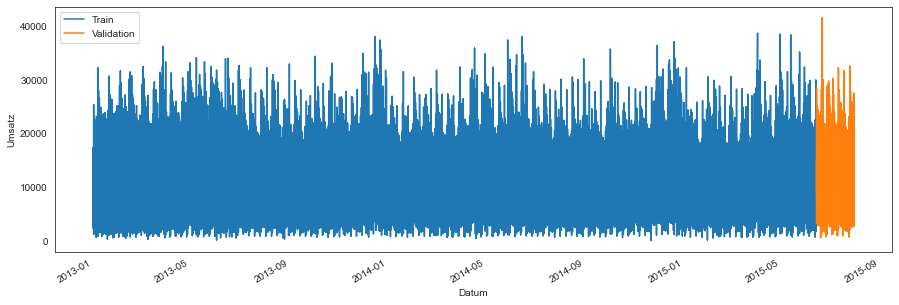

In [20]:
# Plot
fig, ax = plt.subplots(figsize=(15,5))
train.plot(x="Datum", y="Umsatz", ax=ax, label="Train")
validation.plot(x="Datum", y="Umsatz", ax=ax, label="Validation")
ax.set_xlabel("Datum")
ax.set_ylabel("Umsatz")
plt.show()

## Machine Learning Verfahren 1 - SARIMAX<a id="6"></a> <br>

In [21]:
# Notiz von Alice an Niklas: zum weiterarbeiten mit deinem ML-Verfahren:
train_sarimax = train.copy()
test_sarimax = validation.copy()

SARIMAX steht für Seasonal Autoregressive Integrated Moving Average + exogenous variables

In [22]:
display(train_sarimax.head())
display(test_sarimax.head())

,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,UmsatzProKunde,...,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,423,1,1,2013,1,1,2013-01-01,9643,1751,6.939850,...,1,b,a,1270.0,5.0,2014.0,0,0.0,0.0,0
1,530,1,1,2013,1,1,2013-01-01,2907,532,11.347059,...,1,a,c,18160.0,8.0,2010.0,0,0.0,0.0,0
2,335,1,1,2013,1,1,2013-01-01,2401,482,NaN,...,1,b,a,90.0,8.0,2010.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
3,262,1,1,2013,1,1,2013-01-01,17267,2875,11.196491,...,1,b,a,1180.0,5.0,2013.0,0,0.0,0.0,0
4,259,1,1,2013,1,1,2013-01-01,6851,1444,NaN,...,1,b,b,210.0,8.0,2010.0,0,0.0,0.0,0


,Filiale,Tag,Monat,Jahr,Quartal,Wochentag,Datum,Umsatz,Kundenanzahl,UmsatzProKunde,...,Schulferien,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
798486,684,15,6,2015,2,0,2015-06-15,15036,930,10.289017,...,0,d,c,680.0,8.0,2010.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
798487,721,15,6,2015,2,0,2015-06-15,10006,824,8.647391,...,0,a,c,3590.0,9.0,2012.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
798488,408,15,6,2015,2,0,2015-06-15,6936,603,9.066362,...,0,c,a,1560.0,8.0,2010.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
798489,497,15,6,2015,2,0,2015-06-15,12682,1284,9.145885,...,0,a,c,1610.0,8.0,2010.0,0,0.0,0.0,0
798490,469,15,6,2015,2,0,2015-06-15,16014,1751,8.724382,...,0,c,c,710.0,9.0,2005.0,0,0.0,0.0,0


In [23]:
# Zufällige Auswahl treffen
sampled_values = []

# Alle einzigartigen Werte in der Spalte Sortiment ermitteln
unique_sortiments = train_sarimax['Sortiment'].unique()

# Für jeden Wert im Sortiment eine zufällige Filiale auswählen
for sortiment in unique_sortiments:
    filialen = train_sarimax[train_sarimax['Sortiment'] == sortiment]['Filiale'].tolist()
    sampled_values.append(random.choice(filialen))

# Alle einzigartigen Werte in der Spalte Filialentyp ermitteln
unique_filialentypen = train_sarimax['Filialentyp'].unique()

# Für jeden Wert im Sortiment eine zufällige Filiale auswählen
for filialentyp in unique_filialentypen:
    filialen = train_sarimax[train_sarimax['Filialentyp'] == filialentyp]['Filiale'].tolist()
    sampled_values.append(random.choice(filialen))

# Zusätzliche Zufallswerte aus der Spalte Filiale auswählen, um insgesamt 20 Werte zu erhalten
remaining_values = random.sample(train_sarimax['Filiale'].tolist(), 20 - len(sampled_values))
sampled_values.extend(remaining_values)

# # Eine Filiale zufällig wählen
# store_ids = train_sarimax["Filiale"].sample(n=10).values

train_sample_stores = train_sarimax[train_sarimax["Filiale"].isin(sampled_values)]
train_sample_stores.reset_index(inplace=True)
# train_sample_stores.set_index("Datum", drop = True, inplace=True)
test_sample_stores = test_sarimax[test_sarimax["Filiale"].isin(sampled_values)]
test_sample_stores.reset_index(inplace=True)
# test_sample_stores.set_index("Datum", drop = True, inplace=True)

In [24]:
exog_sarimax = pd.get_dummies(train_sample_stores[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])

In [25]:
exog_sarimax = exog_sarimax.apply(pd.to_numeric, errors = "coerce")
exog_sarimax = exog_sarimax.astype("int64")

In [ ]:


# Auto-ARIMA Modell mit wöchentlicher Saisonalität
sarimax_model = pm.auto_arima(train_sample_stores['Umsatz'],
                           exogenous=exog_sarimax, # SARIMAX
                           start_p=2, start_q=2,
                           max_p=5, max_q=5,
                           start_P=1,
                           seasonal=True,  # SARIMA
                           m=52,  # Wöchentliche Saisonalität (1: jährlich, 4: quartalweise, 52: wöchentlich)
                           stepwise=True,  # Effiziente Suche
                           trace=True)  # Zeige den Fortschritt



(5, 1, 1) (1, 0, 0) [52] hat am besten performt

In [ ]:
print(sarimax_model)
print(sarimax_model.order)
print(sarimax_model.seasonal_order)

In [ ]:
test = train_sample_stores.copy()
test["new_index"] = test["Datum"]
test.set_index("new_index", inplace = True, drop = True)

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(test["Umsatz"],
                        order = (2, 1, 2),# sarimax_model.order,
                        seasonal_order= (1, 1, 1, 52), # sarimax_model.seasonal_order,
                        exog = exog_sarimax,
                        enforce_stationarity=True, 
                        enforce_invertibility=False)

results_sarimax = sarimax_model.fit()
print(results_sarimax.summary())

c:\Users\nikla\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               Umsatz   No. Observations:                14112
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 52)   Log Likelihood             -177209.938
Date:                              Mon, 23 Sep 2024   AIC                         354459.875
Time:                                      13:03:26   BIC                         354610.896
Sample:                                           0   HQIC                        354510.141
                                            - 14112                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Wochentag       -60.5701        nan        nan        nan         nan         nan
Datum     

In [35]:
# results_sarimax.save("sarimax")

In [36]:
# results_sarimax.plot_diagnostics(figsize=(15, 8))
# plt.show()

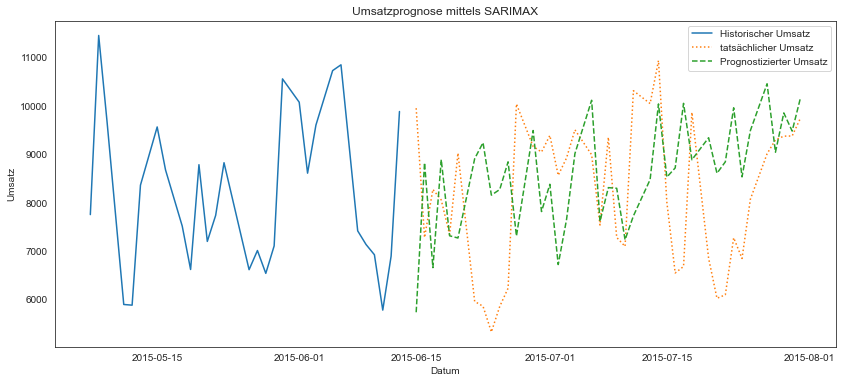

In [37]:
# Eine Filiale zufällig wählen
store_id = train_sarimax["Filiale"].sample(n=1).values[0]

train_sample_store = train_sarimax[train_sarimax["Filiale"] == store_id]
train_sample_store.set_index("Datum", inplace = True, drop= True)
test_sample_store = test_sarimax[test_sarimax["Filiale"] == store_id][:56]
# test_sample_store.set_index("Datum", inplace = True, drop= True)
test_sample_store.reset_index(inplace= True)

# display(test_sample_store)

test_exog_sarimax = pd.get_dummies(test_sample_store[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])
test_exog_sarimax = test_exog_sarimax.apply(pd.to_numeric, errors = "coerce")
test_exog_sarimax = test_exog_sarimax.astype("int64")

# Finden der fehlenden Spalten in df1, die in df2 vorhanden sind
missing_columns = [col for col in exog_sarimax.columns if col not in test_exog_sarimax.columns]

# Hinzufügen der fehlenden Spalten zu df1 und initialisieren mit 0
for col in missing_columns:
    test_exog_sarimax[col] = 0
# display(test_exog_sarimax)


# Auszukommentieren beim Einsatz von statsmodel Sarimax anstatt auto_arima
forecast = results_sarimax.get_forecast(steps=len(test_exog_sarimax), exog=test_exog_sarimax)
forecast_mean = forecast.predicted_mean

# display(forecast.predicted_mean)

# predictions = sarimax_model.predict(n_periods=len(test_sample_store), exogenous=test_exog_sarimax)
# print(predictions)

plt.figure(figsize=(14, 6))
plt.plot(train_sample_store.index[-30:], train_sample_store['Umsatz'][-30:], label='Historischer Umsatz')
plt.plot(test_sample_store["Datum"], test_sample_store['Umsatz'], label='tatsächlicher Umsatz', linestyle = ":")
plt.plot(test_sample_store["Datum"], forecast_mean, label='Prognostizierter Umsatz', linestyle='--')
plt.title('Umsatzprognose mittels SARIMAX')
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.legend()
plt.show()

## Machine Learning Verfahren 2 - Prophet <a id="7"></a> <br>

Prophet Dokumentation: https://facebook.github.io/prophet/docs/quick_start.html

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. The y column must be numeric, and represents the measurement we wish to forecast.

"The best way to handle outliers is to remove them - Prophet has no problem with missing data. If you set their values to NA in the history but leave the dates in future, then Prophet will give you a prediction for their values."

Wir werden die nächsten X Tage je Filientyp vorhersagen, dafür verwenden wir den Traindatensatz.

--

Um selbst Feiertage hinzuzufügen, benötigen wir einen separaten Datensatz mit den Spalten "Feiertag" und "ds". In dem Datensatz müssen alle vergangenen und zukünftigen Feiertage für die Vorhersage vorhanden sein. Prophet bietet aber auch bereits vordefinierte gesetzliche Feiertage, welche unter https://github.com/vacanza/python-holidays/ zu finden sind. Für Deutschland sind dort folgende Feiertage enthalten:

- Neujahr
- Karfreitag
- Ostermontag
- Tag der Arbeit
- Christi Himmelfahrt
- Pfingstmontag
- Tag der deutschen Einheit
- Erster Weihnachtstag
- Zweiter Weihnachtstag

In [878]:
train_prophet = train
validation_prophet = validation
performance_vergleichen = pd.DataFrame(data=[])

Wir erstellen vorab ein Dataframe mit unseren Vorhersagen, damit können wir im letzten Kapitel die Performance unserer beider Machine Learning Verfahren vergleichen.

In [879]:
def vorhersage_prophet(filialennr, anzahl_vorhersagetage, output_anzeigen):

    train_df = train_prophet[train_prophet.Filiale==filialennr][["Datum", "Umsatz"]]        # Datensatz nach Filiale filtern
    train_df = train_df.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)  # Datensatz aufsteigend sortieren
    train_df = train_df.rename(columns = {"Datum": "ds", "Umsatz": "y"})                    # Spalten umbennenen

    model = Prophet(interval_width = 0.95)                                      # Modell mit 95% Konfidenzintervall erstellen
    model.add_country_holidays(country_name='DE')                               # Feiertage in Deutschland hinzufügen
    model.fit(df)                                                               # Modell mit den Daten anreichern                                                              
    future = model.make_future_dataframe(periods=anzahl_vorhersagetage)         # Tage die vorhergesagt werden sollen hinzufügen
    vorhersage = model.predict(future)                                          # Vorhersagen erstellen
    vorhersage_df = vorhersage[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]      # Vorhersagedatensatz speichern

    # Output
    if output_anzeigen==True:
        display(vorhersage_df)
        figure1 = model.plot(vorhersage, xlabel = 'Data', ylabel = 'Vendas')
        figure2 = model.plot_components(vorhersage)

    #train_x_store[train_x_store.Filiale==filialennr][["Datum", "Umsatz"]]

    # Umsätze und Vorhersagen mergen
    performance_merge = vorhersage_df[["ds", "yhat"]].merge(train_x_store[train_x_store.Filiale==filialennr][["Datum", "Umsatz"]],
                                                            left_on='ds', right_on='Datum', how="left")

    # Performance zum vergleichen ablegen
    performance_vergleich = pd.DataFrame(data = {"Datum": performance_merge["ds"],
                                                 "Filiale": filialennr,
                                                 "y_true": performance_merge["Umsatz"],
                                                 "y_pred_alice": performance_merge["yhat"]
                                                 })
    # RSMPE Performance messen und ablegen
    # wurzel [ ((yi-yhat)/yi )^2 ]
    performance_vergleich["rsmpe_alice"] = np.sqrt(np.square(((performance_vergleich["y_true"] - performance_vergleich["y_pred_alice"])/performance_vergleich["y_true"])))

    
    return vorhersage, performance_vergleich

In [ ]:
for i in range(1, 201):
    vorhersage, performance_vergleich = vorhersage_prophet(filialennr=i, anzahl_vorhersagetage=48, output_anzeigen=False)
    performance_vergleichen = pd.concat([performance_vergleichen, performance_vergleich], ignore_index=True)

In [ ]:
performance_vergleichen

### Performance messen mit RSMPE

Compute the score as per the definition on https://www.kaggle.com/c/rossmann-store-sales#evaluation

In [375]:
def rmspe(y_true, y_pred):
    performance_rmspe = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return performance_rmspe

## Vergleich der Machine Learning Verfahren <a id="8"></a> <br>

In [38]:
sample_store_ids = list(range(1, 201))


validation_sample = validation[validation["Filiale"].isin(sample_store_ids)]

In [39]:
sarimax_predictions = pd.DataFrame(columns= ["Datum", "Filiale", "y_true", "y_pred", "rmspe"])
gp_validation_sample = validation_sample.groupby(by = "Filiale")

for store_id, store_validation_data in gp_validation_sample:
    # print(store_validation_data)
    validation_exog = pd.get_dummies(store_validation_data[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])
    validation_exog = validation_exog.apply(pd.to_numeric, errors = "coerce")
    validation_exog = validation_exog.astype("int64")

    # Finden der fehlenden Spalten in df1, die in df2 vorhanden sind
    missing_columns = [col for col in exog_sarimax.columns if col not in validation_exog.columns]

    # Hinzufügen der fehlenden Spalten zu df1 und initialisieren mit 0
    for col in missing_columns:
        validation_exog[col] = 0
    
    forecast = results_sarimax.get_forecast(steps=len(validation_exog), exog=validation_exog)
    forecast_mean = forecast.predicted_mean 
    # print(type(forecast_mean))

    store_results = pd.DataFrame(columns= ["Datum", "Filiale", "y_true", "y_pred", "rmspe"])

    store_results["Datum"] = store_validation_data["Datum"]
    store_results["Filiale"] = store_validation_data["Filiale"]
    store_results["y_true"] = store_validation_data["Umsatz"]
    store_results["y_pred"] = forecast_mean.values
    store_results["rmspe"] = np.sqrt(np.square(((store_results["y_true"] - store_results["y_pred"])/store_results["y_true"])))


    sarimax_predictions = pd.concat([sarimax_predictions, store_results])

display(sarimax_predictions)

,Datum,Filiale,y_true,y_pred,rmspe
799483,2015-06-15,1,5518,5730.181388,0.038453
799965,2015-06-16,1,4852,8820.577491,0.817926
800931,2015-06-17,1,4000,6652.387486,0.663097
802023,2015-06-18,1,4645,8884.493405,0.912700
803901,2015-06-19,1,4202,7310.643089,0.739801
...,...,...,...,...,...
839618,2015-07-27,200,8241,10450.905544,0.268160
840459,2015-07-28,200,7465,9036.684595,0.210540
841051,2015-07-29,200,7013,9848.565822,0.404330
843121,2015-07-30,200,7103,9473.372504,0.333714


In [40]:
sarimax_predictions.to_csv("sarimax_results.csv")